# 1. Load dataset

We first load the Docgenome dataset, the dataset is formed in three layers:
1. `dataset_path`, where the dataset is stored, usually, it containing several discipline folders of which name goes like "cs.CV", "math.CV", etc.
2. `discipline_path`, stores the annotated paper whose [primary category](https://arxiv.org/category_taxonomy) is `discipline`
3. `paper_path`, stores the annotated result for the paper with arxiv id `paper_id`.

In [8]:
import os

# path/to/your/dataset
dataset_path = "../data"

discipline = "physics.gen-ph"
discipline_path = os.path.join(dataset_path, discipline)

In [9]:
import glob

# extract all annotated papers
paper_paths = glob.glob(os.path.join(discipline_path, "*/"))

print(len(paper_paths))

1


Load annotation result of a paper

In [10]:
# load the first paper from the paper_paths
# paper_path = paper_paths[0]

# load a paper with the paper_id
paper_id = "0704.1726"
paper_path = os.path.join(discipline_path, paper_id)

# 2. Layout annotation visualization

We first visualize the layout annotation result. The corresponding files are:
1. `layout_annotation.json`, the layout detection result, it is stored in object detection type of [COCO format](https://cocodataset.org/#format-data)
2. `page_xxxx.jpg`, the JPG format of the paper page, the page index is contained in the filename.

In [11]:
import json

# load layout detection result
layout_annotation_json_file = os.path.join(paper_path, "layout_annotation.json")

with open(layout_annotation_json_file, "r") as f:
    layout_annotation = json.load(f)

now we can visualize the annotation result on page image

In [15]:
page_index = 1  # page_index starts from 0, so this is the second page of the paper

# retrieve the second page image
image_info = layout_annotation["images"]
for image in layout_annotation["images"]:
    if image["id"] == page_index:
        image_path = os.path.join(paper_path, image["file_name"])
        break

# retrieve the bounding boxes of the second image
blocks = [
    block
    for block in layout_annotation["annotations"]
    if block["image_id"] == page_index
]

../data/physics.gen-ph/0704.1726/page_0001.jpg


In [ ]:
# visualize
from PIL import Image, ImageDraw


with Image.open(image_path) as image:
    draw = ImageDraw.Draw(image)
    for block in blocks:
        # note that in COCO format, the bbox is represented as (x0, y0, width, height), where the left-up corner is the origin
        draw.rectangle(
            (
                block["bbox"][0],
                block["bbox"][1],
                block["bbox"][0] + block["bbox"][2],
                block["bbox"][1] + block["bbox"][3],
            ),
            outline="red",
            width=2,
        )
    image.show()

Of course, we can visualize specified category result, for example, equation, the map between category and index are given as follows:

| **Index**  | **Category** | **Notes**                           |
|----------------|-------------------|------------------------------------------|
| 0              | Algorithm         |                                          |
| 1              | Caption           | Titles of Images, Tables, and Algorithms |
| 2              | Equation          |                                          |
| 3              | Figure            |                                          |
| 4              | Footnote          |                                          |
| 5              | List              |                                          |
| 7              | Table             |                                          |
| 8              | Text              |                                          |
| 9              | Text-EQ           | Text block with inline equations         |
| 10             | Title             | Section titles                           |
| 12             | PaperTitle        |                                          |
| 13             | Code              |                                          |
| 14             | Abstract          |                                          |


to visualize only the equation, we select `bbox` whose `category_id` is `2`

In [ ]:
# visualize equation bounding boxes
from PIL import Image, ImageDraw


with Image.open(image_path) as image:
    draw = ImageDraw.Draw(image)
    for block in blocks:
        if block["category_id"] != 2:  # skip if it is not equation
            continue
        # note that in COCO format, the bbox is represented as (x0, y0, width, height), where the left-up corner is the origin
        draw.rectangle(
            (
                block["bbox"][0],
                block["bbox"][1],
                block["bbox"][0] + block["bbox"][2],
                block["bbox"][1] + block["bbox"][3],
            ),
            outline="red",
            width=2,
        )
    image.show()

# 3. Reading annotation visualization

Reading annotation stores the Latex source code for each layout detection block. It can be seen as the Optical Character Recognition (OCR) result of given bounding box. The result is stored in `reading_annotation.json` file.

WARNING: Due to writing style or Macro, the latex source code may not be accurate (for example, it is possible that we cannot compile the chunk of latex source code). Please use the result with caution.

NOTE: The reading annotation records the latex source code for each bounding box. If one paragraph is broken due to cross-page or cross-column, then these two bounding boxes shares the same Latex source code.

To use reading annotation result, it is suggested to crop the bounding box.

In this example, we will crop all equation bounding boxes and their Latex source codes

In [30]:
import json

# load reading detection result
layout_annotation_json_file = os.path.join(paper_path, "reading_annotation.json")

with open(layout_annotation_json_file, "r") as f:
    reading_annotations = json.load(f)

# load all equation blocks
equation_blocks = [
    block for block in reading_annotations if block["category"] == 2
]  # `2` for equation

In [31]:
equation_blocks[0]

{'block_id': 1676,
 'bbox': [792, 656, 904, 696],
 'category': 2,
 'page_index': 1,
 'source_code': '\\begin{equation}\np=\\hbar k,\n\\label{de Broglie relation}\n\\end{equation}'}

We can now visualize the equation blocks and its corresponding Latex source code

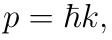

\begin{equation}
p=\hbar k,
\label{de Broglie relation}
\end{equation}


In [34]:
from PIL import Image

# visualize one equation block and the corresponding Latex source code
block_index = 0
block = equation_blocks[block_index]
page_index = block["page_index"]

# find the corresponding page image, image_info is stored in layout_annotation.json
for image in image_info:
    if image["id"] == page_index:
        image_path = os.path.join(paper_path, image["file_name"])
        break

with Image.open(image_path) as image:
    # notice that in reading annotation, the bbox is represented as (x0, y0, x1, y1)
    bbox = (block["bbox"][0], block["bbox"][1], block["bbox"][2], block["bbox"][3])
    cropped_image = image.crop(bbox)

    cropped_image.show()

# print the source code
print(block["source_code"])

# 4. Order annotation visualization

Order annotation specifies the relationship between two bounding boxes. Currently we define the following relationships:

| **Category**  | **Description** | **Example**                           |
|----------------|-------------------|------------------------------------------|
| identical     | two blocks corresponding to the same latex code chunk         |                   paragraphs that cross columns or pages                       |
| peer           | two blocks are both belongs to Title           | \section{introduction}, \section{method} |
| sub              | one block is a child of another block logically          |             \section{introduction} and the first paragraph in Introduction section                             |
| adj             | two adjacent Text blocks            |                    Paragraph1 and Paragraph2                      |
| explicit-cite              | one block cites another block with `ref`          |                 As shown in \ref{Fig: 5}.                         |
| implicit-cite             |  The caption block and the corresponding float environment              |                   \begin{table}\\caption\{A}\\begin{tabular}B\end{tabular}\end{table}, then  A implicit-cite B                       |  

The order relationship helps to organize the paragraphs, determine the explanation to the tables or figures. We can view the order relationship builds a knowledge graph to some extent.

In this example, we will use the result to plot the figures that are posted on our paper.

We first define some utility functions

In [25]:
import argparse
from collections import defaultdict
import math
import os
from pathlib import Path
from typing import Any, Dict, List, Tuple, Union
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

import utils


def draw_arrow_line(
    image: Image.Image,
    point_A: Tuple[float, float],
    point_B: Tuple[float, float],
    width: int = 1,
    color: Tuple[int, int, int] = (0, 255, 0),
) -> Image.Image:
    """
    Draws an arrow line between two points on an image.

    Args:
    image (PIL.Image.Image): The image on which to draw the arrow line.
    point_A (Tuple[float, float]): The first point of the arrow line.
    point_B (Tuple[float, float]): The second point of the arrow line.
    width (int, optional): The width of the arrow line. Defaults to 1.
    color (Tuple[int, int, int], optional): The color of the arrow line. Defaults to (0, 255, 0).

    Returns:
    PIL.Image.Image: The image with the arrow line drawn.

    """
    draw = ImageDraw.Draw(image)
    draw.line((point_A, point_B), width=width, fill=color)

    # Calculate arrowhead vertices
    x0, y0 = point_A
    x1, y1 = point_B
    xb = 0.95 * (x1 - x0) + x0
    yb = 0.95 * (y1 - y0) + y0
    alpha = math.atan2(y1 - y0, x1 - x0) - 90 * math.pi / 180
    a = 8 * math.cos(alpha)
    b = 8 * math.sin(alpha)
    vtx0 = (xb + a, yb + b)
    vtx1 = (xb - a, yb - b)

    # Draw the arrowhead triangle
    draw.polygon([vtx0, vtx1, point_B], fill=color)
    return image


def extract_relations(
    page_index: int,
    order_annotation_data: Dict[str, Any],
    width=None,
) -> List[Tuple[Tuple[float, float], Tuple[float, float], str]]:
    """
    Extracts relations between blocks on a given page or across two adjacent pages.

    Args:
    page_index (int): The index of the page to extract relations for.
    order_annotation_data (Dict[str, Any]): The JSON file containing the order annotation data.
    width (int, optional): The width of the image. If not provided, it assumes a single page.

    Returns:
    List[Tuple[Tuple[float, float], Tuple[float, float], str]]: A list of tuples containing the coordinates of the block centers and the relation type.

    Raises:
    FileNotFoundError: If the order annotation JSON file or any of the image files are not found.

    Usage:
    ```python
    relations = extract_relations(10, order_annotation_data, 1000)
    ```
    """
    page_blocks = defaultdict(list)
    id2blocks = {}
    page2id2 = defaultdict(list)
    for block in order_annotation_data["annotations"]:
        page_blocks[block["page_index"]].append(block)
        id2blocks[block["block_id"]] = block
        page2id2[block["page_index"]].append(block["block_id"])

    # single page
    if width is None:
        relation_tuples = []
        for relation in order_annotation_data["orders"]:
            if relation["from"] not in page2id2[page_index]:
                continue
            if relation["to"] not in page2id2[page_index]:
                continue
            print(relation)
            block_from = id2blocks[relation["from"]]
            block_to = id2blocks[relation["to"]]
            center_from = (
                (block_from["bbox"][0] + block_from["bbox"][2]) / 2,
                (block_from["bbox"][1] + block_from["bbox"][3]) / 2,
            )
            center_to = (
                (block_to["bbox"][0] + block_to["bbox"][2]) / 2,
                (block_to["bbox"][1] + block_to["bbox"][3]) / 2,
            )
            relation_tuples.append((center_from, center_to, relation["type"]))

        return relation_tuples

    # two page
    relation_tuples = []
    for relation in order_annotation_data["orders"]:
        if relation["from"] not in page2id2[page_index] + page2id2[page_index + 1]:
            continue
        if relation["to"] not in page2id2[page_index] + page2id2[page_index + 1]:
            continue
        block_from = id2blocks[relation["from"]]
        block_to = id2blocks[relation["to"]]

        center_x = (block_from["bbox"][0] + block_from["bbox"][2]) / 2
        center_y = (block_from["bbox"][1] + block_from["bbox"][3]) / 2
        if block_from["page_index"] != page_index:
            center_x += width
        center_from = (center_x, center_y)

        center_x = (block_to["bbox"][0] + block_to["bbox"][2]) / 2
        center_y = (block_to["bbox"][1] + block_to["bbox"][3]) / 2
        if block_to["page_index"] != page_index:
            center_x += width
        center_to = (center_x, center_y)

        relation_tuples.append((center_from, center_to, relation["type"]))
    return relation_tuples


def visualize_order_annotation_on_image(
    relation_tuples: List[Tuple[Tuple[float, float], Tuple[float, float], str]],
    image: Image.Image,
) -> None:
    """
    Visualizes the order annotation on an image.

    Args:
    relation_tuples (List[Tuple[Tuple[float, float], Tuple[float, float], str]]):
    A list of tuples containing the coordinates of the block centers and the relation type.
    image (PIL.Image.Image): The image on which to draw the arrow lines.

    Returns:
    None

    Raises:
    FileNotFoundError: If the order annotation JSON file or any of the image files are not found.

    Usage:
    ```python
    relation_tuples = extract_relations(10, order_annotation_data, 1000)
    visualize_order_annotation_on_image(relation_tuples, image)
    ```

    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17, 22))
    ax1.imshow(image)
    color_map = {
        "identical": "green",
        "adj": "blue",
        "peer": "red",
        "implicit-cite": "purple",
        "explicit-cite": "brown",
        "sub": "orange",
        "Unknown": "gray",
    }

    for relation in relation_tuples:
        center_from, center_to, relation_type = relation
        ax1.arrow(
            center_from[0],
            center_from[1],
            center_to[0] - center_from[0],
            center_to[1] - center_from[1],
            fc=color_map[relation_type],
            ec=color_map[relation_type],
            width=3,
        )
    ax1.axis("off")

    legend_handles = []
    legend_labels = []
    relation_type_maps = {
        "identical": "identical",
        "adj": "non-title adjac",
        "peer": "title adjacent",
        "implicit-cite": "implicitly-referred",
        "explicit-cite": "explicitly-referred",
        "sub": "subordinate",
        "Unknown": "unknown",
    }
    for relation_type, color in color_map.items():
        legend_handles.append(
            plt.Line2D(
                [0], [0], color=color, marker="o", linestyle="", label=relation_type
            )
        )
        legend_labels.append(relation_type_maps[relation_type])

    # Add the legend to ax2
    ax2.legend(
        handles=legend_handles,
        labels=legend_labels,
        loc="upper center",
        ncol=len(legend_handles),
    )
    ax2.axis("off")
    plt.tight_layout()

    plt.savefig(f"../output/order_annotation.png", dpi=200)


def visualize_order_annotation_across_pages(path: Path, page_index: int) -> None:
    """
    Visualizes the order annotation across two adjacent pages.

    Args:
    path (Path): The path to the directory containing the images and the order annotation JSON file.
    page_index (int): The index of the first page to be visualized.

    Returns:
    None

    Raises:
    FileNotFoundError: If the order annotation JSON file or any of the image files are not found.

    Usage:
    ```python
    visualize_order_annotation_across_pages("/path/to/directory", 10)
    ```
    """
    order_annotation_file = os.path.join(path, "order_annotation.json")
    image_file1 = os.path.join(path, f"page_{page_index:04}.jpg")
    image_file2 = os.path.join(path, f"page_{page_index+1:04}.jpg")

    # extract blocks in this page
    order_annotation_data = utils.load_json(order_annotation_file)

    # visualize
    image1 = Image.open(image_file1)
    image2 = Image.open(image_file2)

    relation_tuples = extract_relations(page_index, order_annotation_data, image1.width)

    # concatenate adjacent pages
    width = image1.width + image2.width
    image = Image.new("RGB", (width, image1.height))
    image.paste(image1, (0, 0))
    image.paste(image2, (image1.width, 0))

    visualize_order_annotation_on_image(relation_tuples, image)


def visualize_order_annotation_single_page(path: Path, page_index: int) -> None:
    """
    Visualizes the order annotation on a single page.

    Args:
    path (Path): The path to the directory containing the image and the order annotation JSON file.
    page_index (int): The index of the page to be visualized.

    Returns:
    None

    Raises:
    FileNotFoundError: If the order annotation JSON file or any of the image files are not found.

    Usage:
    ```python
    visualize_order_annotation_single_page("/path/to/directory", 10)
    ```
    """
    order_annotation_file = os.path.join(path, "order_annotation.json")
    order_annotation_data = utils.load_json(order_annotation_file)

    image_file = os.path.join(path, f"page_{page_index:04}.jpg")
    image = Image.open(image_file)

    # extract blocks in this page
    relation_tuples = extract_relations(page_index, order_annotation_data)

    # visualize
    visualize_order_annotation_on_image(relation_tuples, image)

We can now visualize relationships in one page

{'type': 'Unknown', 'from': 1684, 'to': 1683}
{'type': 'adj', 'from': 1685, 'to': 1684}
{'type': 'adj', 'from': 1686, 'to': 1685}
{'type': 'adj', 'from': 1687, 'to': 1686}
{'type': 'adj', 'from': 1688, 'to': 1687}
{'type': 'adj', 'from': 1689, 'to': 1688}
{'type': 'adj', 'from': 1690, 'to': 1689}
{'type': 'adj', 'from': 1691, 'to': 1690}
{'type': 'adj', 'from': 1692, 'to': 1691}


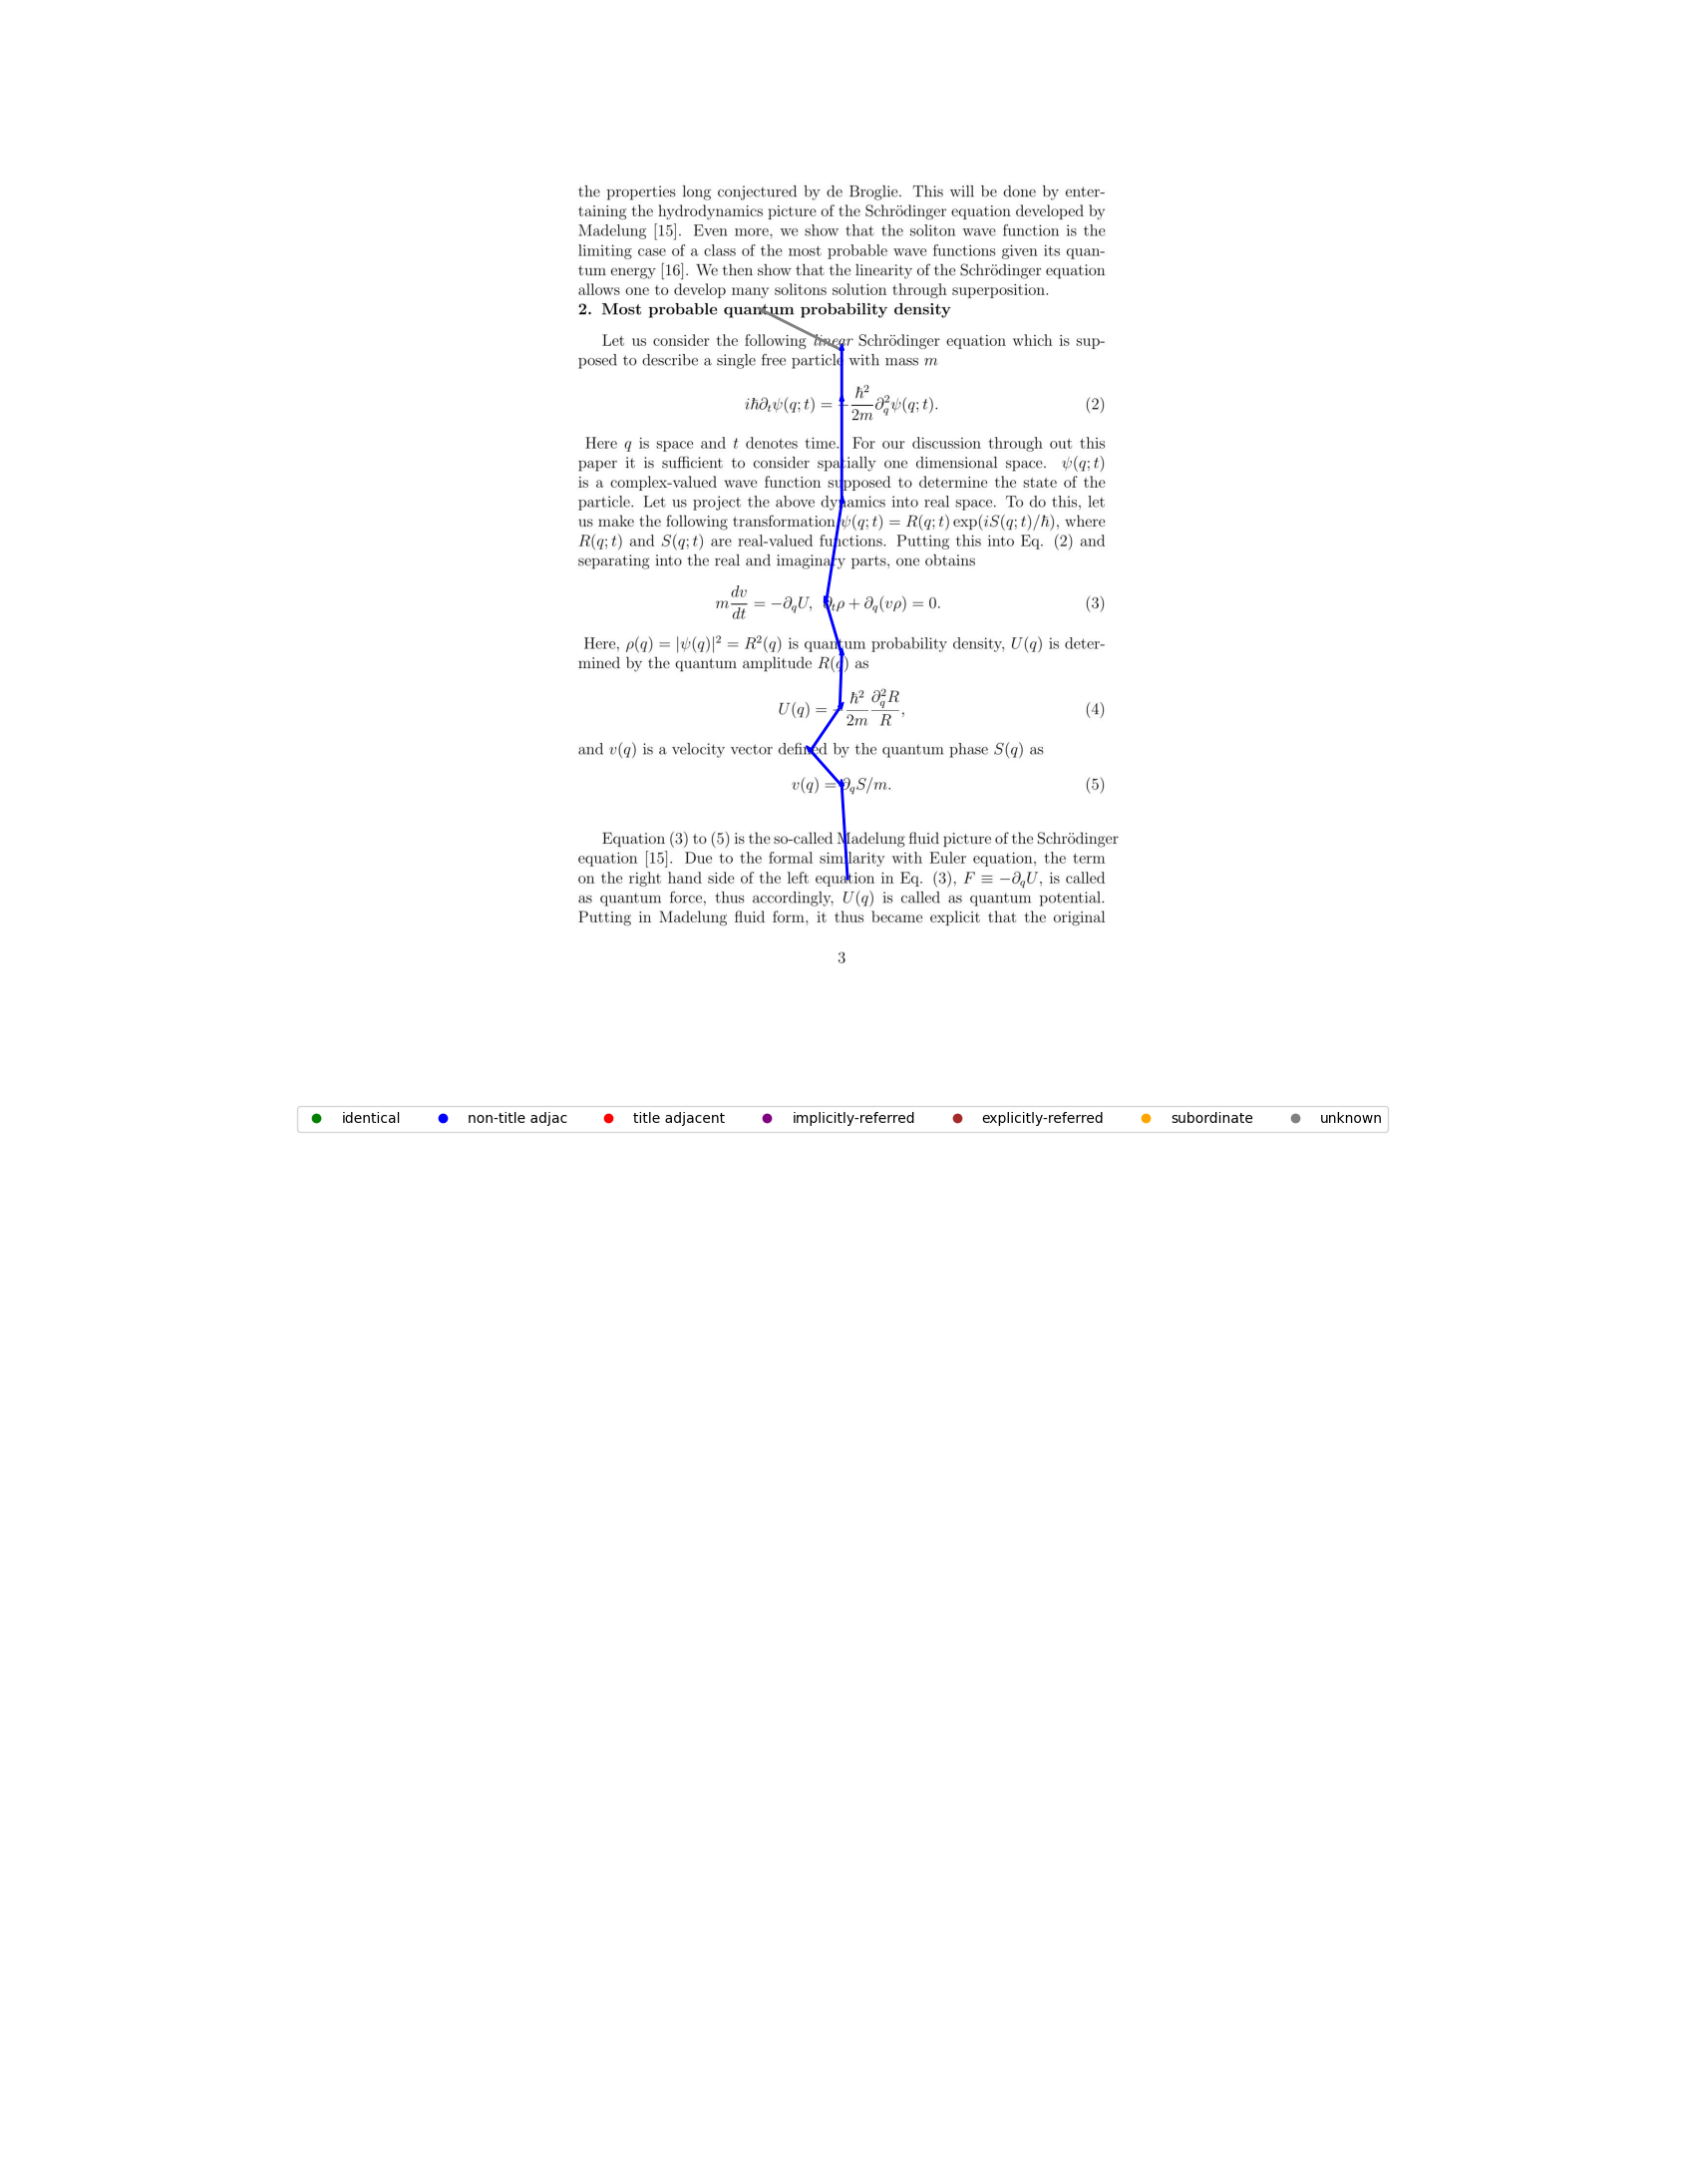

In [26]:
path = "../data/physics.gen-ph/0704.1726"
page_index = 2

visualize_order_annotation_single_page(path, page_index)

We can also visualize relationships between bounding boxes across pages as follows:

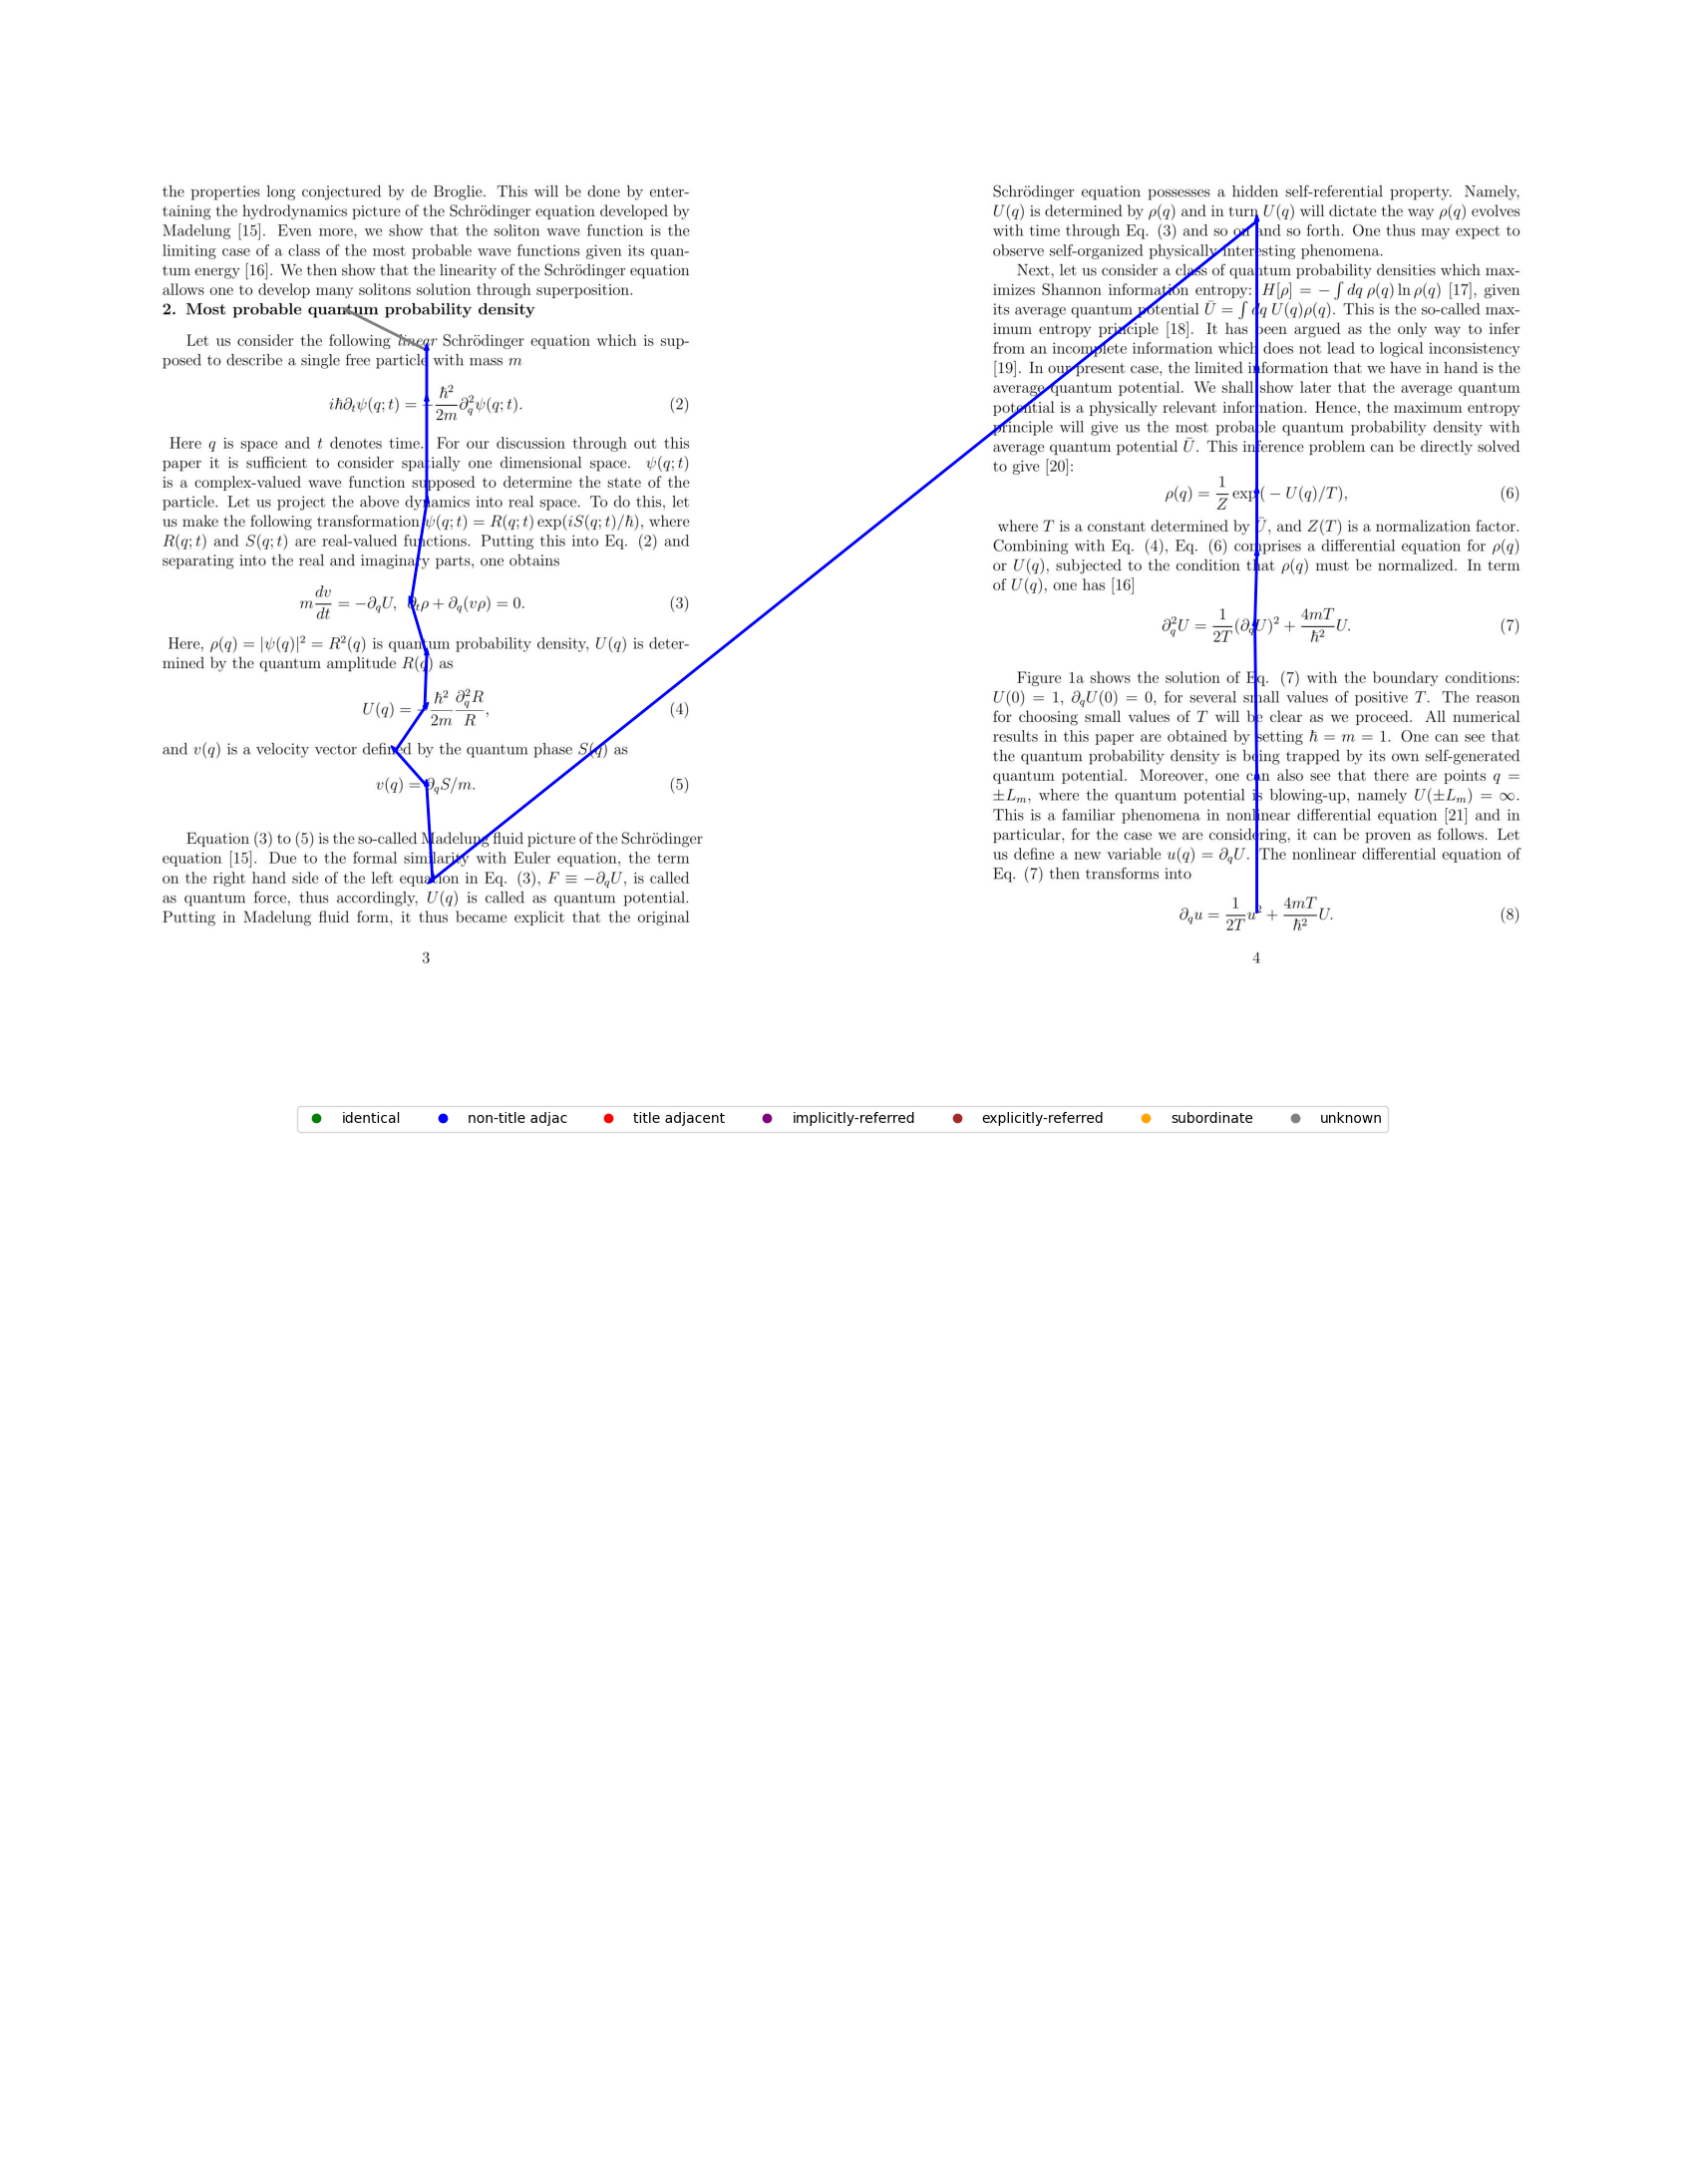

In [28]:
path = "../data/physics.gen-ph/0704.1726"
page_index = 2

visualize_order_annotation_across_pages(path, page_index)

Notice that the annotation is not accurate, please use them with caution.

# 5. Quality report

It is important to design an evaluation toolkit to automatically evaluate the quality of generated data.

In this project, we use several different evaluation metrics to determine the quality of generated data.

The `quality_report.json` file now contains several fields:
1. `num_pages`: how many pages in this paper
2. `num_columns`: the layout of the paper, depends on the last page.
3. `page_quality`: includes the overlap rate for each page and the whole paper.
4. `category_quality`: includes the number of text environments and the number of corresponding bounding boxes

## Overlap

Due to complex paper templates or Latex package conflicts, it is possible that two bounding boxes overlaps with each other. So, we compute the IoU of layout detection results.

Given a list of bounding boxes `bbox_i` of a page, The IoU of the page is given as follows:

$$ 
IoU(bbox_i) = \frac{\sum_i\sum_{j > i}\mathrm{area}(bbox_i\cap bbox_j)}{\sum_{i}\mathrm{area}(bbox_i)}
$$

ideally, the value of IoU is 0, meaning there is no overlap between any two bounding boxes.

However, as mentioned above, the result may be extremely large if there are many overlaps (for example $\geq 10,000$)


# Filling

One other question is: How many bounding boxes are missed when use DocParser to annotate them?


Since we do not have the Ground Truth on layout detection, we use [DocXChain](https://github.com/AlibabaResearch/AdvancedLiterateMachinery/tree/main/Applications/DocXChain) as a reference result to computing the missing detection rate. 

Remark: the result of filling rate is not contained in the `quality_report.json` file.

We use $bbox_{i, x}$ to denote the result produced by DocXChain, and $bbox_{i, d}$ to denote the result produced by DocParser, then the filling rate is computed as follows:

$$
IoU(bbox_{i, x}, bbox_{j, d})=\frac{\sum_i\sum_{j}\mathrm{area}(bbox_{i, x}\cap bbox_{j, d})}{\sum_{i}\mathrm{area}(bbox_{i, x})}
$$

Note that we only care about how many bounding boxes are ignored by DocParser, not to compute the classification accuracy. 

Ideally, the value is around $1$, which means we obtain a similar result compared with DocXChain. In fact, the value maybe very small if there are too many unknown environments.

# category_quality

Category quality indicates how many items of a category in tex file are missed in layout detection results.

For example, if we have rendered 10 `Text` items, however for some reason, we only obtain 9 `Text` blocks, then there is a problem.

Specifically, each field means:
- `category`: the layout detection category name
- `geometry_count`: How many bounding boxes in this category in total
- `reading_count`: How many items are rendered in tex file
- `missing_rate`: the ratio of items that has no corresponding bounding boxes.